(As of mid september 2022. Needs to be cleaned up)

# Notebook for basic plots (no full reconstruction needed)

For part of these plots I reused code from Data Assimilation wrapper.

Easy:
* Location of the plots
* Temporal availability of Proxies:
    * median/mean resolution histogram with each DB separately

* Correlation distance plot (requires psm code)
* Availability on different timescales (requires timeres-resampling scheme, give timescales)


--- Reconstruction plots:
    - Diff Plots Sisal vs iso2k for different models
   
    - GMT Hovmöller Plot for different models -> I have latitudinal mean temperature





In [15]:
import sys
sys.path.append('/home/mchoblet/paleoda')
import xarray as xr
import numpy as np

from types import SimpleNamespace

In [2]:
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns

import cartopy.crs as ccrs
from scipy.stats import linregress
from cartopy.util import add_cyclic_point
import cartopy.feature as cfeature  

import warnings

In [3]:
%load_ext autoreload
%autoreload 2

In [4]:
import psm_pseudoproxy
import utils 
import evaluation

from scipy import stats
from matplotlib.offsetbox import AnchoredText    

In [5]:
# Load Proxy Data

sisal_db=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc')
iso2k_db=xr.open_dataset('/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc')

In [192]:
## location plots

def location_plots(array,labels,title,colors=['violet','blue','brown'],savefig=None):
    """ 
    Plot location of arrays in array [array1, array2,...] on map
    
    savefig: None or path
    """
    ###LOCATIONS
    sns.set_theme(style="white")
    plt.figure(figsize=(12,8))

    mpl.rcParams.update({'font.size': 18})

    #Define projection
    ax = plt.axes(projection=ccrs.PlateCarree())

    # add coastlines
    ax.add_feature(cfeature.COASTLINE)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)
    #ax.stock_img()

    #add lat lon grids
    gl = ax.gridlines(draw_labels=True, color='grey', alpha=0.8, linestyle='--')
    gl.top_labels = False
    gl.ylabels_right = False
    ax.set_extent([-180, 180, -90, 90])
    
    for i,k in enumerate(array):
        ax.scatter(k.lon,k.lat,s=100,c=colors[i],edgecolor='black',transform=ccrs.PlateCarree(),label=(labels[i]+' ('+str(len(k.site))+')'))
    
    plt.legend(fontsize=15,loc='center left')
    plt.title(title,fontsize=30)
    # y-axis
    ax.text(-0.1, 0.5, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    # x-axis
    ax.text(0.5, -0.14, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    
    if savefig is not None:
        plt.savefig('/home/mchoblet/paleoda/results/plots/locations.pdf', format='pdf',bbox_inches='tight')


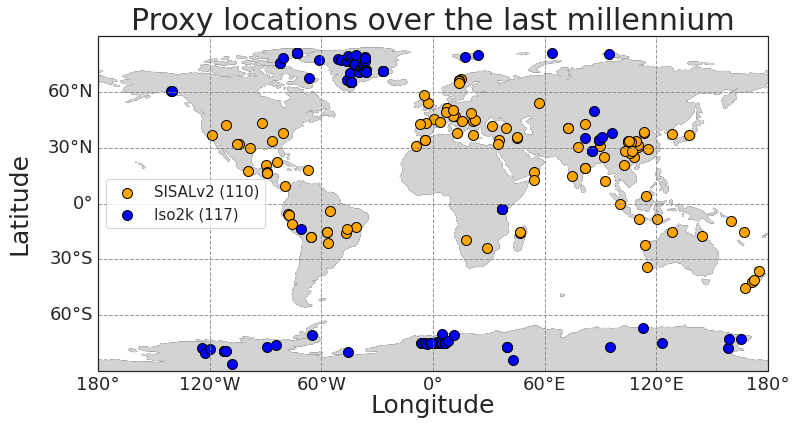

In [194]:
location_plots([sisal_db['d18O'],iso2k_db['d18O']],labels=['SISALv2','Iso2k'],title='Proxy locations over the last millennium', colors=['orange','blue'],savefig=True)

# Resolution and availability


In [268]:
 def availability(array,labels,title,colors=['violet','blue','brown'],savefig=None):
    
    sns.set_theme()

    mpl.rcParams['xtick.labelsize'] = 18
    mpl.rcParams['ytick.labelsize'] = 18
    plt.rc('legend',**{'fontsize':30})
    
    plt.figure(figsize=(10,4))
    for i,a in enumerate(array):
        a.count(dim='site').plot(label=labels[i],color=colors[i])

    #plt.ylabel('Number of records',fontsize=20)
    plt.xlabel('Time (Year AD)',fontsize=20)
    plt.ylabel('',fontsize=20)
    legend=plt.legend(fontsize=18)
    #legend.get_title().set_fontsize('0')
    #plt.axvline(cftime.DatetimeNoLeap(850,1,1),c='black',ls='--')
    
    #plt.text(cftime.DatetimeNoLeap(850,1,1),-12.5,'850',rotation=0,fontsize=30)
    plt.title(title,fontsize=20)
    
    if savefig is not None:
        plt.savefig('/home/mchoblet/paleoda/results/plots/availability.pdf', format='pdf',bbox_inches='tight')

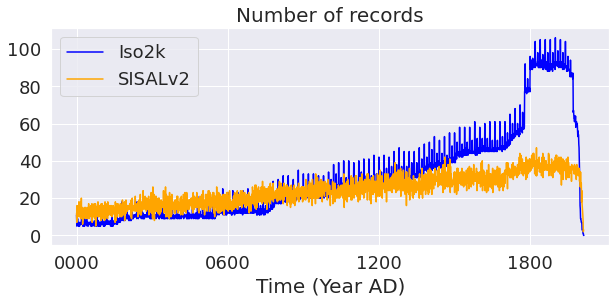

In [269]:
availability([iso2k_db['d18O'],sisal_db['d18O']],labels=['Iso2k','SISALv2'],colors=['blue','orange'],title='Number of records',savefig=True)

In [207]:
## resolution of proxies

def res_hist(array,labels,title,mode=np.median,colors=['blue','orange'],bins=np.arange(1,30,1),savefig=None):
    sns.set_style('darkgrid')
    plt.figure(figsize=(9,6))
    for i,db in enumerate(array):
        resols=[]
        for s in db.site:
            years=db.sel(site=s).dropna('time').time.dt.year.values
            time_diff=years[1:]-years[:-1]
            res=mode(time_diff)
            resols.append(res)
        plt.hist(resols,bins=bins,color=colors[i],label=labels[i],alpha=0.7)
    plt.title(title,fontsize=25)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Years',fontsize=22)
    plt.ylabel('Records',fontsize=22)
    plt.legend(fontsize=20)

    if savefig is not None:
        if savefig!=  '':
            plt.savefig('/home/mchoblet/paleoda/results/plots/res_hist.pdf', format='pdf',bbox_inches='tight')
        else:
            plt.savefig(savefig, format='pdf',bbox_inches='tight')

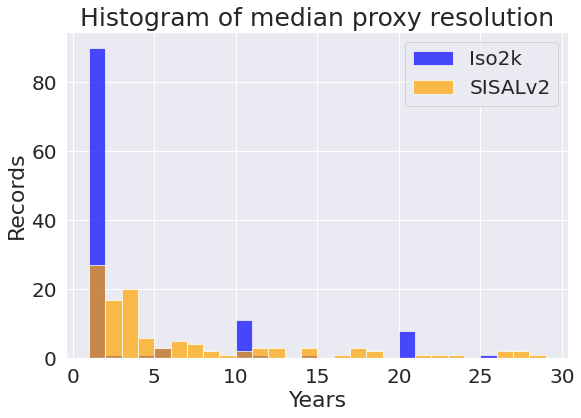

In [208]:
res_hist([iso2k_db['d18O'],sisal_db['d18O']],labels=['Iso2k','SISALv2'],title='Histogram of median proxy resolution',bins=np.arange(1,30,1),savefig=True)

In [212]:
cfg={
'vp':{
'd18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf': '/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
'evap': '/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'slp': None,
},
'avg':None,
'oro': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'obsdata':['/home/mchoblet/paleoda/data/proxy_dbs/sisal_db.nc','/home/mchoblet/paleoda/data/proxy_dbs/iso2k_db.nc'],
'obs_var':[['d18O','d18O_precision'],['d18O','d18O_precision']], #name of variables and uncertainties in proxy_db files
'proxy_error': [0.1,0.1], #irrelevant for PPE
'time_scales': ['median','median'],
'proxy_time':['0000','2015'],
'time': ['0000','2015'],
'resample': True,
'resample_mode': 'nearest',
'mask': 3, 
###MULTI-TIMESCALE
#'timescales':[1,5,10,20], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'timescales':[1,3,6,12,24], #list of timescales (have to be true divisors of longest timescale (block size)) Timescale 1 always required! 
'reuse': True,
'ppe': {'use':False},
    
    
}

In [213]:
def resampler(c,pp_y_all):
    #RESAMPLE PROXIES
    #Suppres warnings. Bad practice, but warnings in resampling part are annoying (some pandas stuff)
    warnings.simplefilter("ignore",category=DeprecationWarning) 
    warnings.simplefilter("ignore",category=FutureWarning) 

    #time arrays for each resolution
    length=int(c.proxy_time[1])-int(c.proxy_time[0])
    times_list=[xr.DataArray(xr.cftime_range(start=c.proxy_time[0],periods=(length//i+1),freq=str(i)+'YS',calendar='365_day'),dims='time') for i in c.timescales]

    #adapt times_list (cut end in case it doesn't fit perfectly with largest block size)
    #I needed an (eventually) different times_list for resampling the proxies
    #this could definitely be nicer
    new_times_list=[]
    time_sc=c.timescales
    for i,t in enumerate(times_list):
        ts=time_sc[i]
        end=str(((int(c.time[1])-int(c.time[0]))//ts)*ts+int(c.time[0]))
        if end>c.proxy_time[1]:
            end=str(((int(c.proxy_time[1])-int(c.time[0]))//ts)*ts+int(c.time[0]))
        new_times_list.append(t.sel(time=slice(c.time[0],end)))
    times_list=new_times_list

    #drop where there are no values in the final time range (only without ppe)
    first_time=times_list[0][0]
    last_time=times_list[0][-1]
    
    if c.ppe['use']==False:
        pp_y_all_new=[]
        for idx,pp in enumerate(pp_y_all):
            pp_l=pp.sel(time=slice(first_time,last_time))
            pp2=pp.copy(deep=True)
            for s in (pp.site):
                avail_times=pp_l.sel(site=s).dropna('time').time.values            
                if len(avail_times)==0:
                    pp2=pp2.drop_sel(site=s.values)
            pp_y_all_new.append(pp2)
        pp_y_all=pp_y_all_new
    
        #one list for each proxy_db containing the mean/median/min timeresolution rounded to given timescale, controled by config timescales
        print('COMPUTE TIMERESOLUTION OF PROXIES')
        timeres_list=utils.proxy_timeres(c,pp_y_all) 
    
    #cut the proxies in time according to kalman_filter settings. it's important to cut only at that step here
    #else we don't get the real timeresolution of the proxy
    pp_y_all=[pp.sel(time=slice(first_time,last_time)) for pp in pp_y_all]
    
    #list of Dataarrays for each timescale
    if c.ppe['use']==False:
        if c.resample:
            print('RESAMPLING THE PROXIES')
            lisst=utils.resample_proxies(c,timeres_list,times_list,pp_y_all)
        
        #case where we don't want the fancy resampling technique, just assigning the values as they are (eventually means if more than one value for each subblock)
        elif len(c.timescales) > 1:
            lisst=utils.noresample_proxies(c,timeres_list,times_list,pp_y_all)
            
        #just assign each proxy to annual and keep the timeseries as they are. Proxies are going to be used as they are available in the original table
        #Separate concetanation because xr-merge doesn't work due to the (necessary) metadata in the prox_dbs
        else:
            sites=[]; vals=[]; lats=[]; lons=[]
            for db in pp_y_all:
                sites.append(db.site.values); vals.append(db.values); lats.append(db.lat.values); lons.append(db.lon.values)

            time=pp_y_all[0].time #time has been set to the same in all databases
            #get site axis in data, not to be confounded with time axis
            ax=db.get_axis_num('site')
            sites=np.concatenate(sites,axis=-1); vals=np.concatenate(vals,axis=ax); lats=np.concatenate(lats,axis=-1); lons=np.concatenate(lons,axis=-1)
            da=xr.DataArray(vals,coords=dict(time=time,site=sites))
            da['lat']=('site',lats); da['lons']=('site',lons)
            #count Database members and add as an attribute
            integers=(list(map(int,list(map(float,sites)))))
            da.attrs['DB_members']=np.unique(integers,return_counts=True)[1]
            lisst=[da]
    return lisst

In [214]:
#proxy databases and errors list of DAs, final time given by c.proxy_time.
#site has 0.+..., 1.+... to mark the distinct proxy dbs
pp_y_all,pp_r_all=utils.proxy_load(c)

>>>>>LOADING PROXY DATA


In [113]:
lisst=resampler(c,pp_y_all)

COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:28<00:00,  4.16it/s]


In [114]:
cfg['reuse']=False
c=SimpleNamespace(**cfg)
lisst_noreuse=resampler(c,pp_y_all)

COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:10<00:00, 11.45it/s]


In [159]:
cfg['timescales']=[1,3,8,24]
cfg['reuse']=True
c=SimpleNamespace(**cfg)

lisst_13824=resampler(c,pp_y_all)

COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:23<00:00,  4.91it/s]


In [156]:
cfg['reuse']=False
c=SimpleNamespace(**cfg)
lisst_13824_noreuse=resampler(c,pp_y_all)

COMPUTE TIMERESOLUTION OF PROXIES
RESAMPLING THE PROXIES
resampling of proxies in each database


100%|██████████| 117/117 [00:14<00:00,  7.84it/s]


In [149]:
#plt.rc('legend',**{'fontsize':40})

def temp_availability(lisst,timescales=[1,3,6,12,24],savefig=None,loc=4):
    fig,ax=plt.subplots(nrows=1,ncols=len(timescales),figsize=(30,6),sharey=True)
    sns.set_style()
    sns.set(font_scale = 1)

    plt.suptitle('Available proxies per timescale. Median resolution.',fontsize=25,y=1.03)
    #palette=sns.color_palette('colorblind',n_colors=len(cfg['multi_timescale']['timescales']))
    palette=sns.color_palette('colorblind',n_colors=2)
    siss=[]
    isos=[]
    for ii,i in enumerate(lisst):
        lim=i.attrs['DB_members'][0]
        #marker='o',markersize=2,
        #sis=ax[ii].fill_between(i.time.values,np.count_nonzero(~np.isnan(i)[:,:lim],axis=-1),ls='-',label='Sisal',color=palette[1],alpha=0.6)
        iso=ax[ii].fill_between(i.time.values,np.count_nonzero(~np.isnan(i)[:,lim:],axis=-1),ls='-',label='iso2k', color=palette[0],alpha=0.6)
        sis=ax[ii].fill_between(i.time.values,np.count_nonzero(~np.isnan(i)[:,:lim],axis=-1),ls='-',label='Sisal',color=palette[1],alpha=0.6)

        ax[ii].fill_between(i.time.values,np.max(np.stack([np.count_nonzero(~np.isnan(i)[:,lim:],axis=-1),np.count_nonzero(~np.isnan(i)[:,:lim],axis=-1)]),axis=0),np.count_nonzero(~np.isnan(i)[:,:],axis=-1),ls='--',label='both',color='grey',alpha=0.3)
        #ax[ii].fill_between(i.time.values,np.count_nonzero(~np.isnan(i)[:,:],axis=-1),ls='--',label='both',color='grey',alpha=0.3)
        #ax[ii].set_title(('Timescale: '+ str(timescales[ii])),fontsize=20)
        ax[ii].set_title((str(timescales[ii])),fontsize=20)
        
        #ax[ii].grid()
        #siss.append(sis)
        #isos.append(iso)
        ax[ii].tick_params(labelsize=20)
        #ax[ii].sxticks(fontsize=20)
        #ax[ii].yticks(fontsize=20)
        #ax[ii].xlabel('Years',fontsize=22)
        
    legend0=plt.legend(title='Database',loc=loc,fontsize=16)
    legend0.get_title().set_fontsize('18')
    fig.subplots_adjust(wspace=0.03)

    if savefig is not None:
        if savefig!='':
            plt.savefig('/home/ldap-server/draco/notebooks/paleoda/paleoda/plots/temporal_avail.pdf', format='pdf',bbox_inches='tight')
        else:
            plt.savefig(savefig, format='pdf',bbox_inches='tight')

    return 


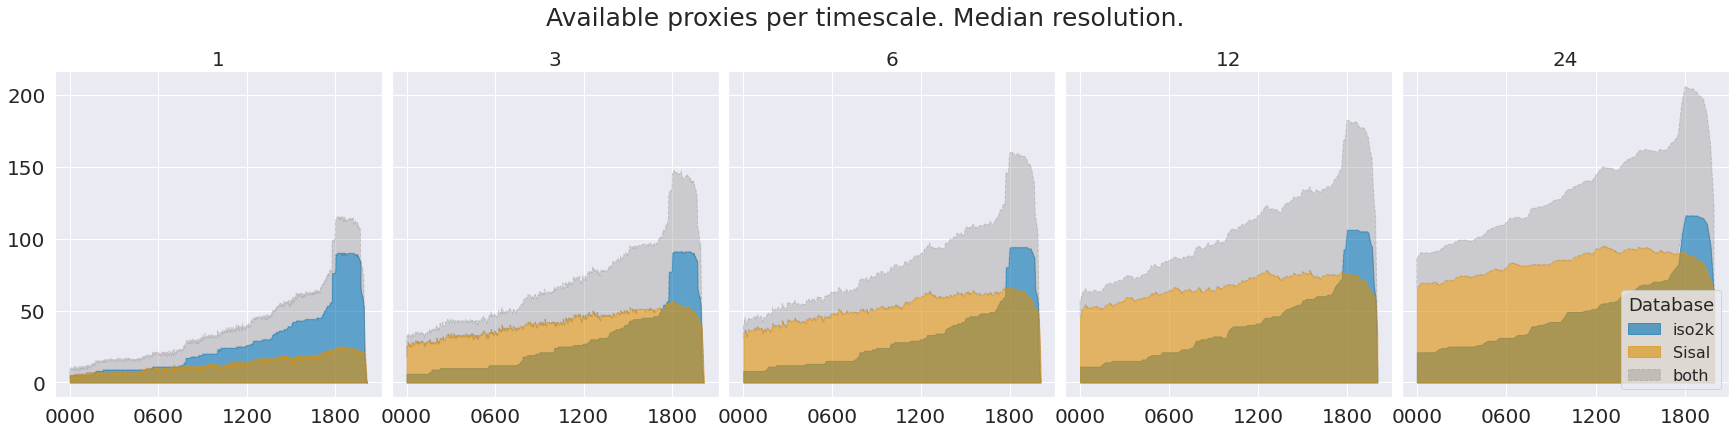

In [150]:
temp_availability(lisst,timescales=[1,3,6,12,24])

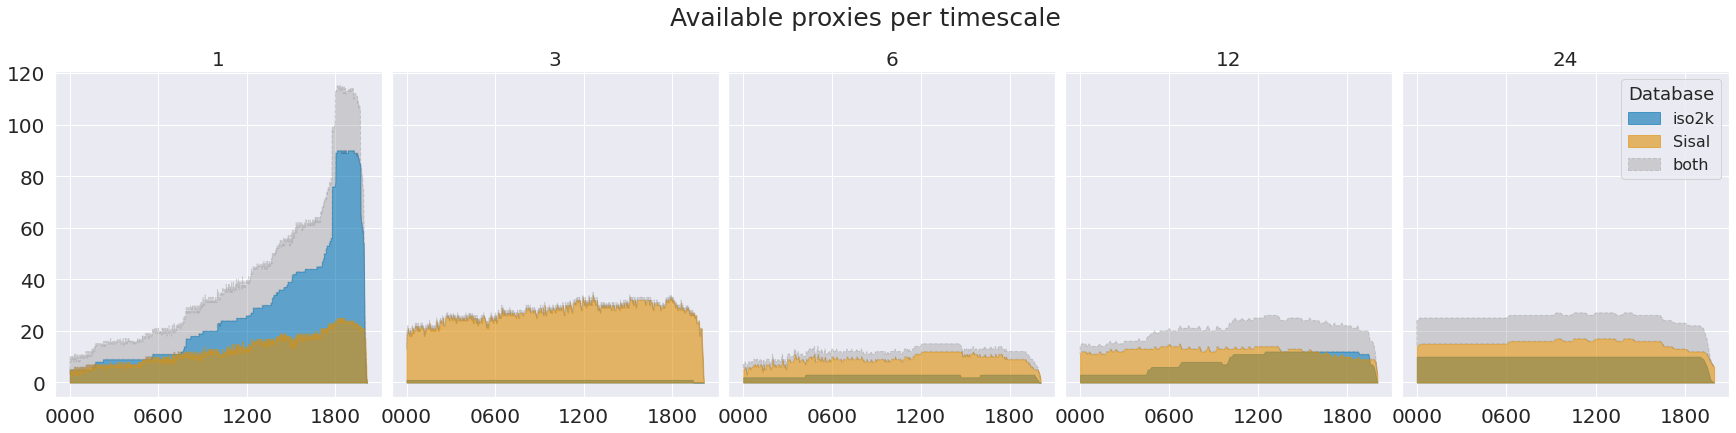

In [148]:
temp_availability(lisst_noreuse,timescales=[1,3,6,12,24],loc='upper right')

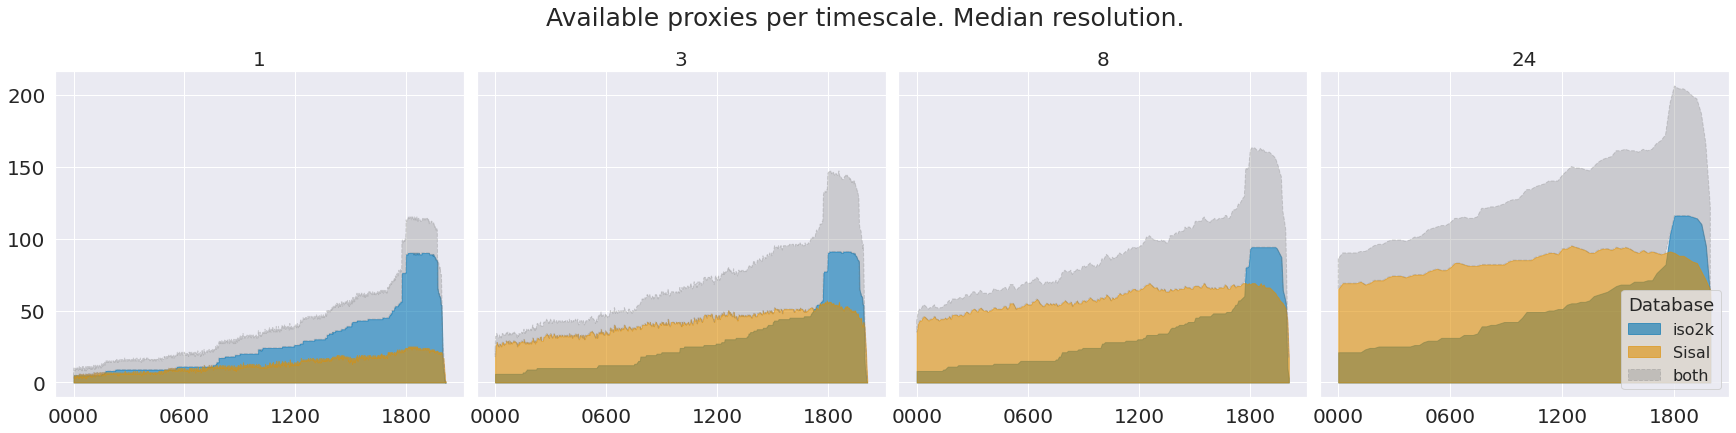

In [160]:
temp_availability(lisst_13824,timescales=[1,3,8,24])

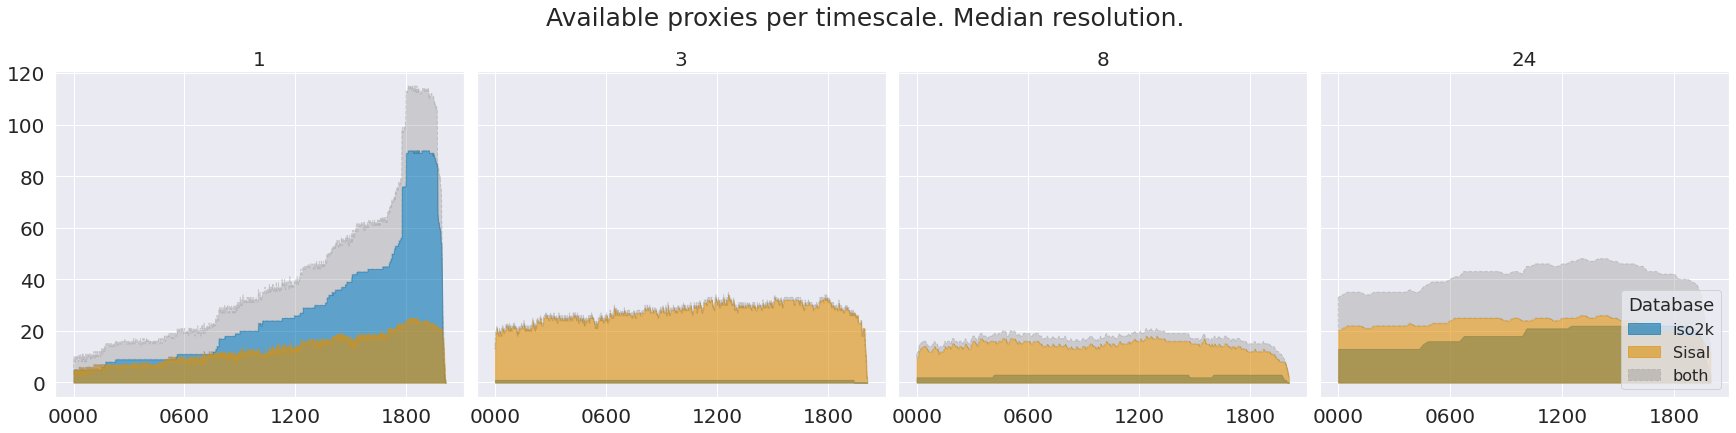

In [158]:
temp_availability(lisst_13824_noreuse,timescales=[1,3,8,24])

## Mean comparison plot 

- for all models (5 supblots in a row
- also plot the height difference as colorbar!


In [216]:
cfg['psm']=['speleo','icecore']
cfg['interpol']='dw'
cfg['var_psm']=['d18O','d18O'] #only relevant if psm=None  
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': True, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
cfg['icecore']={
    'weighting':'prec', #None(pure d18O) / prec (d180 prec weighted)
    'height': True, #height correction: True requires orography of model and 'elev' coordinate for proxy_db. Requires that proxy_db has a coordinate 'lapse rate' (e.g. i attributed -0.15 to non polar porxies and -0.28 to polar ones (per 100m)
    'filter': False, #If True the PSM-function from PRYSM which takes into account diffusion is applied. 
}



In [217]:
paths={
'iCESM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc',
       },
'isoGSM':{'d18O':'/home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc',
       },    
'Echam':{'d18O':'/home/mchoblet/paleoda/data/model_data/ECHAM5_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/ECHAM5_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/ECHAM5_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/ECHAM5_tsurf_850_1849.nc',
       },
'GISS':{'d18O':'/home/mchoblet/paleoda/data/model_data/GISS_d18O_850_1849.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/GISS_evap_850_1849.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/GISS_prec_850_1849.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/GISS_tsurf_850_1849.nc',
'slp': '/home/mchoblet/paleoda/data/model_data/GISS_slp_850_1849.nc',
       },
'iHadCM3':{'d18O':'/home/mchoblet/paleoda/data/model_data/iHADCM3_d18O_801_1952.nc',
'evap':'/home/mchoblet/paleoda/data/model_data/iHADCM3_evap_801_1952.nc',
'prec':'/home/mchoblet/paleoda/data/model_data/iHADCM3_prec_801_1952.nc',
'tsurf':'/home/mchoblet/paleoda/data/model_data/iHADCM3_tsurf_801_1952.nc',
'slp':'/home/mchoblet/paleoda/data/model_data/iHADCM3_slp_801_1952.nc',
       }
} 

#I checked once again that nothing with the longitudes is wrong (all go from 0 to 360)
oro_dic={
'iCESM':'/home/mchoblet/paleoda/data/orographies/icesm_oro.nc',
    'isoGSM':'/home/mchoblet/paleoda/data/orographies/ccsm_oro.nc',
'Echam': '/home/mchoblet/paleoda/data/orographies/echam_oro.nc',
'GISS':'/home/mchoblet/paleoda/data/orographies/giss_oro.nc',
'iHadCM3':'/home/mchoblet/paleoda/data/orographies/hadcm3_oro.nc',
}

In [219]:
pp_y_all

[<xarray.DataArray 'd18O' (time: 2016, site: 110)>
 [221760 values with dtype=float64]
 Coordinates:
   * site        (site) <U5 '0.2' '0.3' '0.4' '0.7' ... '0.277' '0.278' '0.293'
   * time        (time) object 0000-01-01 00:00:00 ... 2015-01-01 00:00:00
     lat         (site) float64 42.87 -4.067 45.43 -24.0 ... -11.27 32.0 20.75
     lon         (site) float64 81.75 304.6 0.78 29.18 ... 284.2 254.8 102.7
     elev        (site) float64 ...
     mineralogy  (site) object ...
     sitename    (site) object ...,
 <xarray.DataArray 'd18O' (time: 2016, site: 117)>
 [235872 values with dtype=float64]
 Coordinates:
   * time                  (time) object 0000-01-01 00:00:00 ... 2015-01-01 00...
   * site                  (site) <U5 '1.127' '1.103' '1.112' ... '1.107' '1.111'
     lat                   (site) float64 ...
     lon                   (site) float64 ...
     elev                  (site) float64 ...
     min_time_resolution   (site) float64 ...
     mean_time_resolution  (site

In [220]:
prior

<xarray.Dataset>
Dimensions:  (lon: 144, lat: 96, time: 1000)
Coordinates:
  * lon      (lon) float64 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat      (lat) float64 90.0 88.11 86.21 84.32 ... -84.32 -86.21 -88.11 -90.0
  * time     (time) object 0850-01-01 00:00:00 ... 1849-01-01 00:00:00
    year     (time) int64 850 851 852 853 854 855 ... 1845 1846 1847 1848 1849
Data variables:
    d18O     (time, lat, lon) float64 -18.77 -18.77 -18.77 ... -42.79 -42.79
    evap     (time, lat, lon) float64 0.9018 0.9062 0.915 0.9191 ... 0.0 0.0 0.0
    prec     (time, lat, lon) float64 9.301 9.3 9.3 9.299 ... 3.528 3.528 3.528
    tsurf    (time, lat, lon) float32 249.3 249.3 249.3 ... 221.8 221.5 221.5
Attributes:
    units:         per mil
    grid_mapping:  spatial_ref

In [227]:
sisal_ = []
iso2k_ = []
prior_dict={}
for i,p in paths.items():
    cfg['vp'] = p
    cfg['oro'] = oro_dic[i]
    cfg['interpol']=None
    
    c=SimpleNamespace(**cfg)
    prior, attributes, prior_raw=utils.prior_preparation(c)
    prior_dict[i]=prior
    HXfull_all=utils.psm_apply(c,prior,prior_raw, pp_y_all)
    sisal_.append(HXfull_all[0])
    iso2k_.append(HXfull_all[1])
    

Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
>>>>>>>>>>>>>APPLYING FRACTIONATION
USING ICECORE PSM
>>>>>>>>>>>>>APPLYING HEIGHT CORRECTION
Load d18O  from  /home/mchoblet/paleoda/data/model_data/CCSM_d18O_851_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CCSM_evap_851_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CCSM_prec_851_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CCSM_tsurf_851_1850.nc
computi

In [231]:
def mean_plot(pp_y,HX_full,names=list(oro_dic.keys()),title='Mean value comparison for SISAL',vmin=-3000,vmax=3000,minval=-20,loc='lower left',savefig=None):
    
    """
    Input: pp_y, HX_full are lists of the values for one database for each model
    names: names of models
    vmin, vmax for height dots (not used)
    #Code still holds option how to add a colorbar with height differences
    """

    fig, axs = plt.subplots(nrows=1,ncols=len(HX_full),figsize=(30,8),sharex=True)
    fig.suptitle(title,fontsize=40)
    colors=np.concatenate(([(0,0,0)],sns.color_palette(palette='colorblind', n_colors=5)))


    cm=mpl.cm.get_cmap('bwr',7)
    mean_proxy=pp_y.mean('time')

    for x,pp in enumerate(HX_full):

            oro=xr.open_dataset(oro_dic[names[x]])['oro']
            oro=psm_pseudoproxy.obs_from_model(oro,lat=pp.lat.values,lon=pp.lon.values,interpol=None)

            elev=pp.elev
            vmin=-3000
            vmax=3000
            z=(elev-oro)

            mean_prior=pp.mean(dim='time')#.sel(site=mean_proxy.site.values)

            slope, intercept, r, p, std_err = stats.linregress( mean_proxy,mean_prior)

            def myfunc(x):
                return slope * x + intercept

            mymodel = list(map(myfunc, mean_proxy))

            string= str(np.round(r,decimals=2))+',(' + str(np.round(slope,decimals=2)) +','+str(np.round(intercept,decimals=2)) + ')'+''

            axs[x].plot(mean_proxy, mymodel,color='blue',ls='-',label=string)

            #p=axs[x].scatter(mean_proxy,mean_prior,c=z,s=150,cmap=cm, edgecolors='black',vmin=vmin,vmax=vmax)
            p=axs[x].scatter(mean_proxy,mean_prior,c='lightblue',s=150,cmap=cm, edgecolors='black',vmin=vmin,vmax=vmax)

            axs[x].set_title(names[x],fontsize=30)

            #axs[x].set_xlabel('proxy',fontsize=30)
            axs[x].set_xlim((minval,1))
            axs[x].set_ylim((minval,1))
            #set number of ticks
            axs[x].locator_params(axis='y', nbins=5)
            axs[x].locator_params(axis='x', nbins=3)
            
            axs[x].plot(np.arange(minval,1,1),np.arange(minval,1,1),color='grey',ls='--')
            
            if x==0:
                axs[x].set_ylabel('simulation',fontsize=30)
                #axs[x].yaxis.set_ticklabels([-20,-15,-10,-5,0])
            else:
                #axs[x].set_ylabel('',fontsize=30)
                #axs[x].set_yticks([])
                axs[x].yaxis.set_ticklabels([])

            #textbox with regression parameter
            box_text = '\n'.join((
            r'Corr: %.2f' % r,
            r'Slope: %.2f' % slope,
            r'Intercept: %.2f' % intercept,
            ))

            text_box = AnchoredText(box_text, frameon=True, loc=loc, pad=0.5, prop=dict(fontsize=20))
            plt.setp(text_box.patch, facecolor='white', alpha=0.5)
            axs[x].add_artist(text_box)


    #axs[0].set_xlabel('Common x-label')

    fig.text(0.5, -0.05, 'Proxies', ha='center',fontsize=30)

    plt.tight_layout() 

    if savefig is not None:
        if savefig==True:
            plt.savefig('/home/mchoblet/paleoda/results/plots/mean_plot_sisal.pdf', format='pdf',bbox_inches='tight')
        else:
            plt.savefig(savefig, format='pdf',bbox_inches='tight')
    
    """
    p0 = axs[0].get_position().get_points().flatten()
    p2 = axs[-1].get_position().get_points().flatten()

    ax_cbar1 = fig.add_axes([p0[0]*5.2, -0.05, (p2[2]-p0[0])/2, 0.05])
    cb=fig.colorbar(p, cax=ax_cbar1, orientation='horizontal',cmap=cm)
    cb.set_label('Elevation proxy - model',fontsize=30)
    """

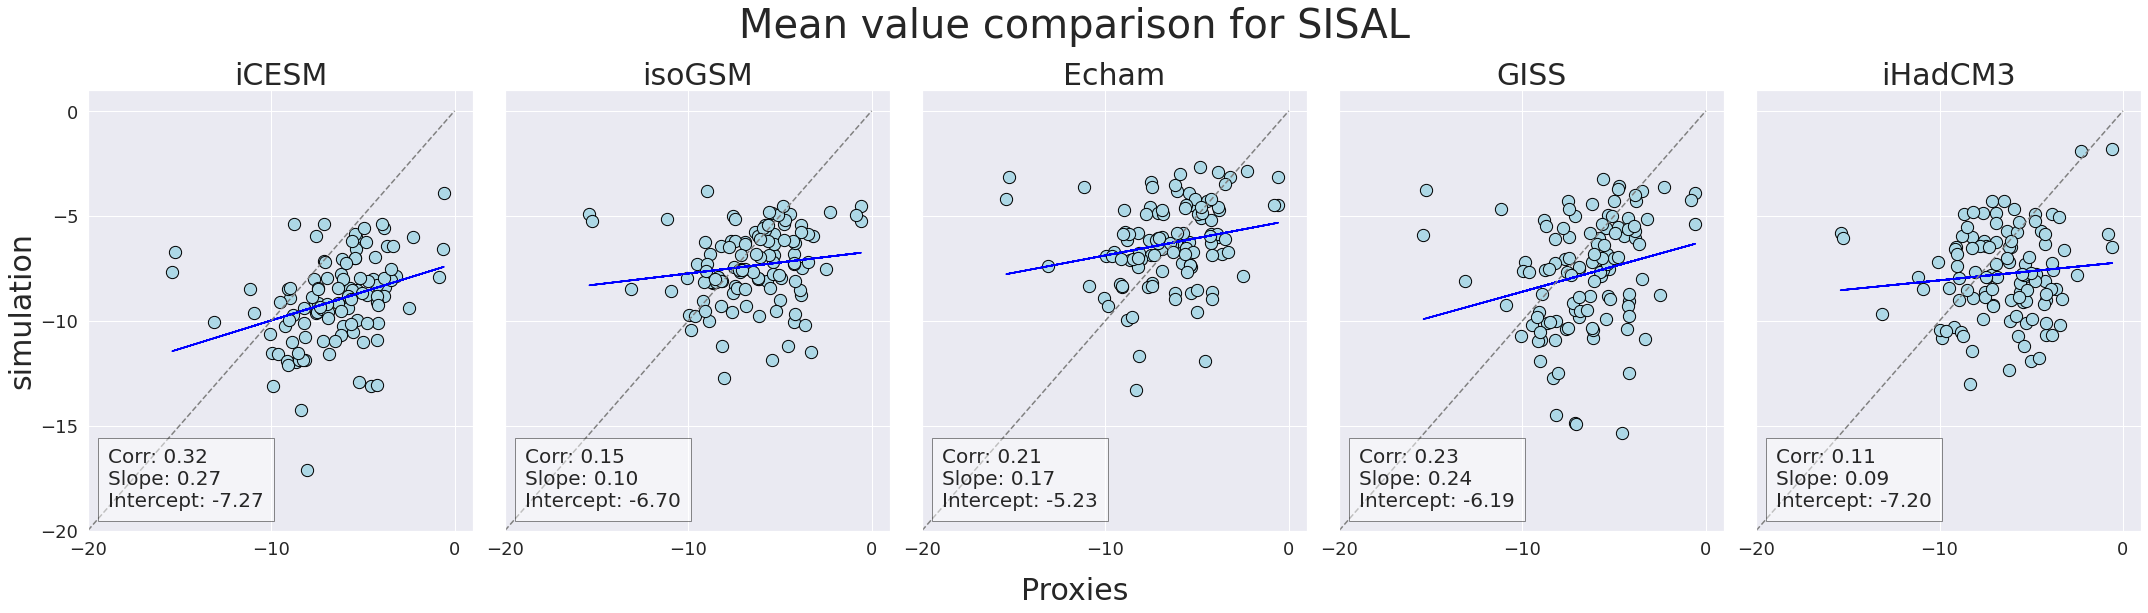

In [232]:
mean_plot(pp_y_all[0],sisal_,names=list(oro_dic.keys()),title='Mean value comparison for SISAL',vmin=-3000,vmax=3000,minval=-20,savefig=True)

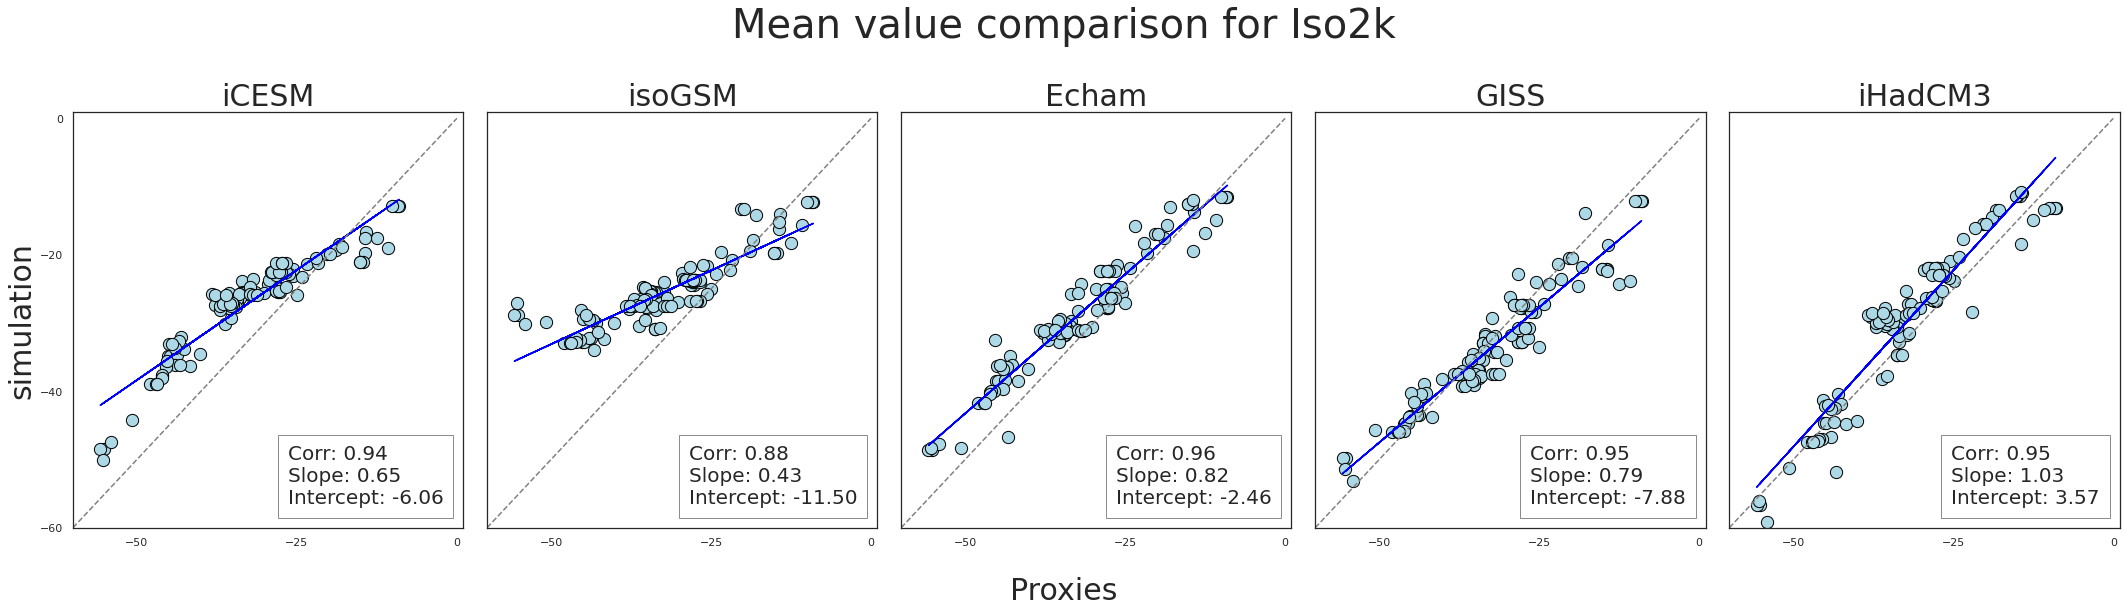

In [263]:
mean_plot(pp_y_all[1],iso2k_,names=list(oro_dic.keys()),title='Mean value comparison for Iso2k',vmin=-3000,vmax=3000,minval=-60,loc='lower right',savefig='/home/mchoblet/paleoda/results/plots/mean_plot_iso.pdf')

In [233]:
def mean_plot_map(pp_y,HX_full,names=list(oro_dic.keys()),title='Mean value comparison for SISAL',vmin=-10,vmax=10,xfac=1,yfac=1,savefig=None):
    """
    Plot of mean value difference of locations on the map.
    names must have same order as HX_full (!)
    xfac and yfac for tuning the plot
    
    """
    
    sns.set_theme(style="white")
    
    #fig, axs = plt.subplots(nrows=1,ncols=len(HX_full),figsize=(40,4),sharex=True,subplot_kw={'projection':ccrs.Robinson()})
    fig, axs = plt.subplots(nrows=1,ncols=len(HX_full),figsize=(40*xfac,4*yfac),sharex=True,subplot_kw={'projection':ccrs.PlateCarree()})
    fig.suptitle(title,fontsize=40)
    colors=np.concatenate(([(0,0,0)],sns.color_palette(palette='colorblind', n_colors=5)))

    cm=mpl.cm.get_cmap('bwr')
    mean_proxy=pp_y.mean('time')

    mpl.rcParams.update({'font.size': 22})

    for x,pp in enumerate(HX_full):
        
            # add coastlines
            axs[x].add_feature(cfeature.COASTLINE)
            axs[x].add_feature(cfeature.LAND, facecolor='lightgray', zorder=1)

            #add lat lon grids
            gl = axs[x].gridlines(draw_labels=False, color='grey', alpha=0.8, linestyle='--')
            #gl.top_labels = False
            #gl.ylabels_right = False
            #gl.ylabels_left = False
            #axs[0].set_extent([-180, 180, -90, 90])
        
            mean_prior=pp.mean(dim='time')#.sel(site=mean_proxy.site.values)
            p=axs[x].scatter(mean_proxy.lon,mean_proxy.lat,c=(mean_proxy-mean_prior),s=150, cmap=cm, transform=ccrs.PlateCarree(), edgecolors='black',vmin=vmin,vmax=vmax)
            axs[x].set_title(names[x],fontsize=30)
    
    plt.tight_layout() 
    """
    plt.legend(fontsize=18,loc='center left')
    plt.title(title,fontsize=30)
    # y-axis
    ax.text(-0.08, 0.5, 'Latitude', va='bottom', ha='center',
            rotation='vertical', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    # x-axis
    ax.text(0.5, -0.12, 'Longitude', va='bottom', ha='center',
            rotation='horizontal', rotation_mode='anchor',
            transform=ax.transAxes,fontsize=25)
    
    if savefig is not None:
        plt.savefig('/home/ldap-server/draco/notebooks/paleoda/paleoda/plots/locations.pdf', format='pdf',bbox_inches='tight')
    """
    p0 = axs[2].get_position().get_points().flatten()
    p2 = axs[3].get_position().get_points().flatten()
    from matplotlib import ticker
    ax_cbar1 = fig.add_axes([p0[0], 0, (p0[2]-p0[0]), 0.05])
    cb=fig.colorbar(p, cax=ax_cbar1, orientation='horizontal',cmap=cm)
    cb.ax.tick_params(labelsize=20)
    tick_locator = ticker.MaxNLocator(nbins=3)
    cb.locator = tick_locator
    cb.update_ticks()
    cb.set_label('proxy - simulation',fontsize=30)
    
    if savefig is not None:
        if savefig==True:
            plt.savefig('/home/mchoblet/paleoda/results/plots/mean_plot_map_sisal.pdf', format='pdf',bbox_inches='tight')
        else:
            plt.savefig(savefig, format='pdf',bbox_inches='tight')
    
    return




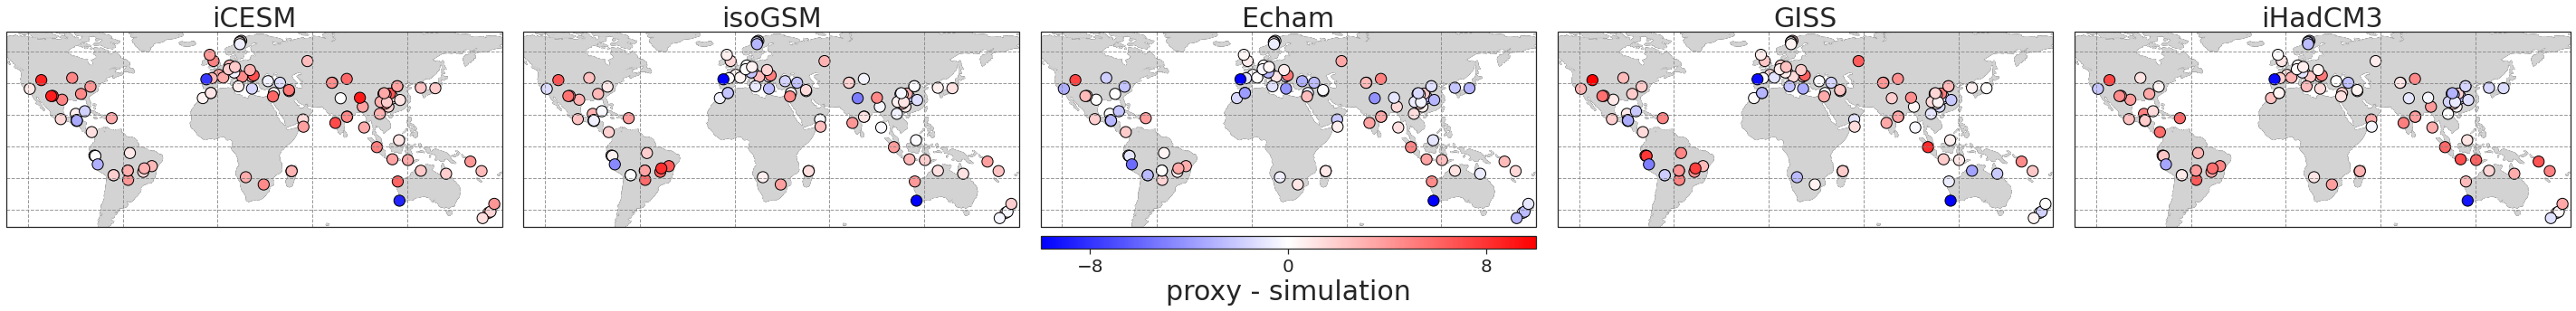

In [235]:
mean_plot_map(pp_y_all[0],sisal_,names=list(oro_dic.keys()),title='',vmin=-10,vmax=10,savefig=True)

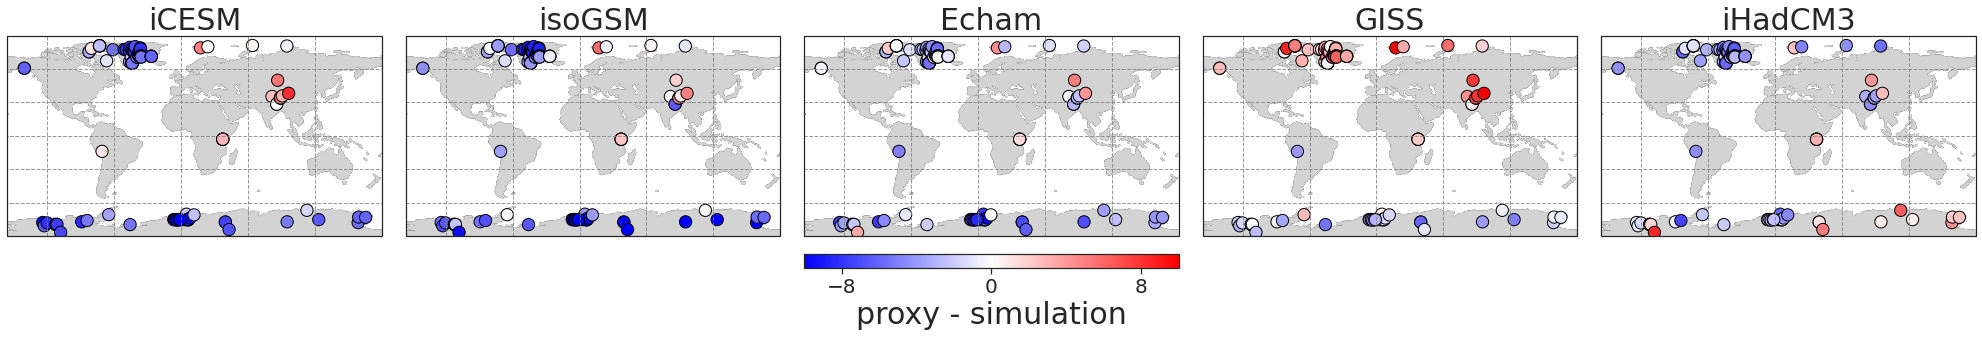

In [262]:
mean_plot_map(pp_y_all[1],iso2k_,names=list(oro_dic.keys()),title='',vmin=-10,vmax=10,xfac=0.7,yfac=1,savefig='/home/mchoblet/paleoda/results/plots/mean_plot_map_iso.pdf')

# Correlation distance plots

Start with one Model + One Database

Ingredients:
 - prior background fields 
 - proxy estimates from HX_full

In [236]:
model='iCESM'
variables=['tsurf','prec','d18O']

cfg['vp'] = paths[model]
cfg['oro'] = oro_dic[model]

c=SimpleNamespace(**cfg)
prior, attributes, prior_raw=utils.prior_preparation(c)
proxies=pp_y_all[0]

dic_0={}
#correlation without psm
cfg['psm']=[None]
cfg['interpol']=None
cfg['var_psm']=['d18O'] #only relevant if psm=None  

c=SimpleNamespace(**cfg)
HXfull_all=utils.psm_apply(c,prior,prior_raw, [proxies])

for v in variables:
    Xf=prior[v].stack(z=('lat','lon'))
    data=HXfull_all[0]
    HXf=xr.DataArray(data.values,coords=dict(time=sisal_[0].time.values,site=data.site.values))
    dic_0[v]=evaluation.CD(Xf,HXf,data.lat,data.lon,nbins=100)
    
dic_inf={}
#correlation adding infiltration weighting
cfg['psm']=['speleo']
cfg['interpol']=None
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':False, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
c=SimpleNamespace(**cfg)
HXfull_all=utils.psm_apply(c,prior,prior_raw, [proxies])

for v in variables:
    Xf=prior[v].stack(z=('lat','lon'))
    data=HXfull_all[0]
    HXf=xr.DataArray(data.values,coords=dict(time=sisal_[0].time.values,site=data.site.values))
    dic_inf[v]=evaluation.CD(Xf,HXf,data.lat,data.lon,nbins=100)

dic_frac={}
#correlation adding fractionation
cfg['psm']=['speleo']
cfg['interpol']=None
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
c=SimpleNamespace(**cfg)
HXfull_all=utils.psm_apply(c,prior,prior_raw, [proxies])

for v in variables:
    Xf=prior[v].stack(z=('lat','lon'))
    data=HXfull_all[0]
    HXf=xr.DataArray(data.values,coords=dict(time=sisal_[0].time.values,site=data.site.values))
    dic_frac[v]=evaluation.CD(Xf,HXf,data.lat,data.lon,nbins=100)

Load d18O  from  /home/mchoblet/paleoda/data/model_data/CESM_d18O_850_1850.nc
computing yearly average
Load evap  from  /home/mchoblet/paleoda/data/model_data/CESM_evap_850_1850.nc
computing yearly average
Load prec  from  /home/mchoblet/paleoda/data/model_data/CESM_prec_850_1850.nc
computing yearly average
Load tsurf  from  /home/mchoblet/paleoda/data/model_data/CESM_tsurf_850_1850.nc
computing yearly average
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION


In [237]:
#using a constant temperature for fractionation. should be equal dic_inf
dic_frac_m={}
#correlation adding fractionation
cfg['psm']=['speleo']
cfg['interpol']=None
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'mean', #'mean'
    'filter': False, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
c=SimpleNamespace(**cfg)
HXfull_all=utils.psm_apply(c,prior,prior_raw, [proxies])

for v in variables:
    Xf=prior[v].stack(z=('lat','lon'))
    data=HXfull_all[0]
    HXf=xr.DataArray(data.values,coords=dict(time=sisal_[0].time.values,site=data.site.values))
    dic_frac_m[v]=evaluation.CD(Xf,HXf,data.lat,data.lon,nbins=100)
    
dic_filt={}
#correlations adding
cfg['psm']=['speleo']
cfg['interpol']=None
cfg['speleo']={
    'weighting':'inf', #None(pure d18O) / prec (d180 prec weighted)/ inf (d18O prec-evap weighted)
    'height': False, #height correction: True requires orography of model + proxy_db must have a coordinate 'elev'. Lapse rate assumed -0.28 for isotopes and -0.65 for temperature
    'fractionation':True, #requires tsurf (in 'vp')
    'fractionation_temp': 'regular', #'mean'
    'filter': True, #True: convolution of yearly means with 2.5 year transit time, or float: transit time
    't_time': 2.5, #if filter equal true, use this as a transit time
}
c=SimpleNamespace(**cfg)
HXfull_all=utils.psm_apply(c,prior,prior_raw, [proxies])
for v in variables:
    Xf=prior[v].stack(z=('lat','lon'))
    data=HXfull_all[0]
    HXf=xr.DataArray(data.values,coords=dict(time=sisal_[0].time.values,site=data.site.values))
    dic_filt[v]=evaluation.CD(Xf,HXf,data.lat,data.lon,nbins=100)



USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
USING SPELEO PSM
>>>>>>>>>>>>>GETTING MONTHLY d18O Data
>>>>>>>>>>>>>APPLYING FRACTIONATION
>>>>>>>>>>>>>APPLYING KARST FILTER


In [ ]:
# label_size = 16
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 
sns.set_style("darkgrid")

def plot_corr(cor_dict, ylabel=False,legend=False,title=None,savefig=None):
    
    #plt.figure(figsize=(7,5),tight_layout = {'pad': 0})
    plt.figure(figsize=(7,5),constrained_layout=True)
    plt.locator_params(axis='y', nbins=6)
    plt.locator_params(axis='x', nbins=5)
    
    for var,data in cor_dict.items():
        if var=='d18O':
            var='$\delta^{18}$O'
        strg=r'('+var+',$\delta^{18}$O$_{PSM}$)'
        plt.scatter(data[2],data[0],s=3,label=strg)
            
    if ylabel:
        plt.ylabel('Corr',fontsize=22)
    if legend:
        lgnd=plt.legend(fontsize=16,numpoints=1)
        #change the marker size manually for both lines
        for i,p in enumerate(cor_dict.items()):
            lgnd.legendHandles[i]._sizes=[30]
    
    if title is not None:
        plt.title(title,fontsize=22)
    plt.ylim(-0.3,1)
    plt.xlabel('Distance [km]',fontsize=20)
    plt.tight_layout() 
    
    
    if savefig is not None:
        strg='/home/mchoblet/paleoda/results/plots/'+savefig+'.pdf'
        plt.savefig(strg, format='pdf',bbox_inches='tight')
    plt.show()

/tmp/ipykernel_258239/2987746891.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


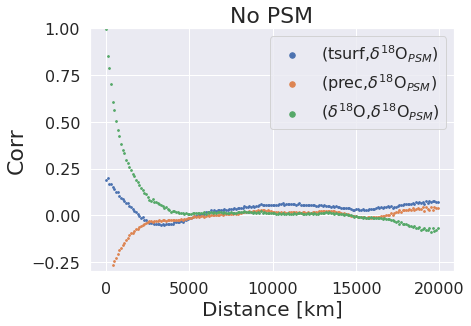

In [254]:
plot_corr(dic_0,ylabel=True,legend=True, title='No PSM',savefig='corr_nopsm')

/tmp/ipykernel_258239/2987746891.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


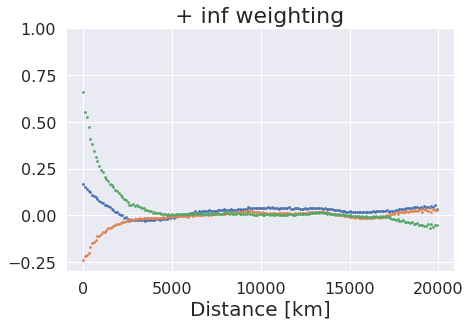

In [255]:
plot_corr(dic_inf,ylabel=False,legend=False,title='+ inf weighting',savefig='corr_inf')

/tmp/ipykernel_258239/2987746891.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


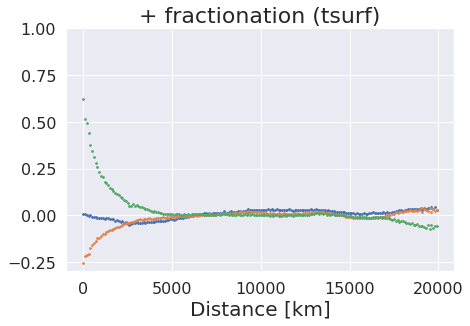

In [256]:
plot_corr(dic_frac,ylabel=False,legend=False,title='+ fractionation (tsurf)',savefig='corr_frac')

/tmp/ipykernel_258239/2987746891.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


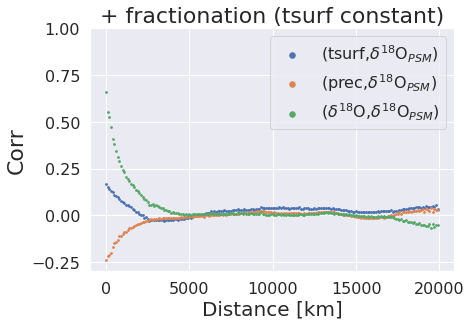

In [257]:
plot_corr(dic_frac_m,ylabel=True,legend=True,title='+ fractionation (tsurf constant)')

/tmp/ipykernel_258239/2987746891.py:31: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


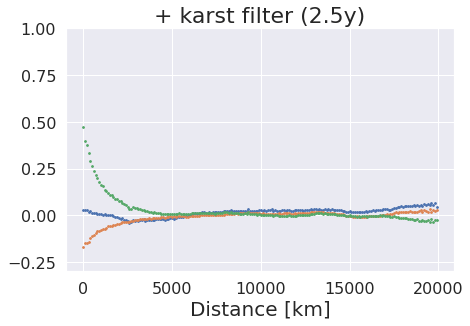

In [258]:
plot_corr(dic_filt,ylabel=False,legend=False, title='+ karst filter (2.5y)',savefig='corr_karst')